# Cut-through Switching Test

In [112]:
from dpkt.pcap import Reader
from dpkt.ethernet import Ethernet
from decimal import Decimal
from pandas import DataFrame, cut
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns

## Measurement

## reading and parsing raw data

In [86]:
CONFIGURATION = {"Kontron": {
                    "no_cts": "KONTRON_cut-through-NULL-NULL_no-CTS_1518_0.0percent.pcap",
                    "cts": "KONTRON_cut-through-NULL-NULL_CTS_1518_0.0percent.pcap"
                    },
                 "FibroLAN": {
                    "no_cts": "FibroLAN_cut-through-NULL-NULL_no-CTS_1518_0.0percent.pcap",
                    "cts": "FibroLAN_cut-through-NULL-NULL_CTS_1518_0.0percent.pcap"
                    }
                 }

In [63]:
def get_data(file, vendor, setting):
    f = open(file, "rb")
    pcap = Reader(f)

    framesizes = []
    latencies = []

    for ts, buf in pcap:
        hexstream = buf.hex()
        ts_nsec = Decimal(int(hexstream[108:116], 16))
        ts_sec = Decimal(int(hexstream[100:108], 16))
        ts_send = ts_sec + Decimal("0." + str(ts_nsec).zfill(9))
        ts_recv = ts
        latency = ts_recv * Decimal(1e6) - ts_send * Decimal(1e6)
        framesize = Ethernet(buf).ip.len + 18

        framesizes.append(framesize)
        latencies.append(float(latency))

    df = DataFrame(data=list(zip(framesizes, latencies)),
                   columns=["Framesize", "Latency us"])
    df.to_csv("/home/arch/validation_paper/{}/{}/measurements.csv".format(vendor, setting),
              index=False,
              header=True,
              sep="\t")

    return df

## original parsed data

In [87]:
dfs = []

for vendor, config in CONFIGURATION.items():
    for qos, pcap in config.items():
        dfs.append(get_data("/mnt/harddrive/data/pcaps/{}".format(pcap), vendor, qos))

<AxesSubplot:xlabel='Framesize', ylabel='Latency us'>

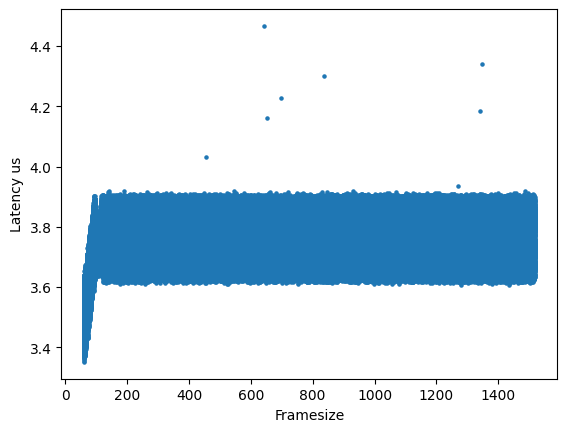

In [89]:
dfs[1].plot(x="Framesize", y="Latency us", kind="scatter", marker=".")

In [37]:
df_sorted = df.sort_values("Framesize").reset_index(drop=True)

bins = [b for b in range(60, 1519)]
bins.insert(0, 0)

df_sorted["bins"] = cut(df_sorted["Framesize"], bins=bins)

stats = df_sorted.groupby(['bins'])['Latency us'].agg(['mean',
                                                       'median',
                                                       'count',
                                                       'std'])

ci95_hi = []
ci95_lo = []
ci99_hi = []
ci99_lo = []

for i in stats.index:
    mn, md, c, s = stats.loc[i]
    ci95_hi.append(md + 1.96*s/sqrt(c))
    ci95_lo.append(md - 1.96*s/sqrt(c))
    ci99_hi.append(md + 2.576*s/sqrt(c))
    ci99_lo.append(md - 2.576*s/sqrt(c))

stats['ci95_hi'] = ci95_hi
stats['ci95_lo'] = ci95_lo
stats['ci99_hi'] = ci99_hi
stats['ci99_lo'] = ci99_lo


framesizes = [i for i in range(60, 1519)]
stats["Framesize"] = framesizes

## First Bit to Last Bit

In [27]:
for i, row in stats.iterrows():
    stats.at[i, "median F-L"] = row["median"] + row["Framesize"] * 8 / 1e3

In [28]:
diff = []

for i, row in stats.iterrows():
    diff.append(row["ci99_hi"]-row["ci99_lo"])

In [29]:
columns = ["Framesize",
           "mean",
           "median",
           "median F-L",
           "std",
           "ci95_hi",
           "ci95_lo",
           "ci99_hi",
           "ci99_lo"
           ]

stats[columns].to_csv("/home/arch/validation_paper/evaluation-{}/evaluation-{}_stats.csv".format(measurement, measurement),
                      index=False,
                      header=True,
                      sep="\t")

In [30]:
stats["std"].describe()

count    1459.000000
mean        0.027891
std         0.037994
min         0.020100
25%         0.021940
50%         0.022382
75%         0.022807
max         0.476628
Name: std, dtype: float64

## sorted and sampled data

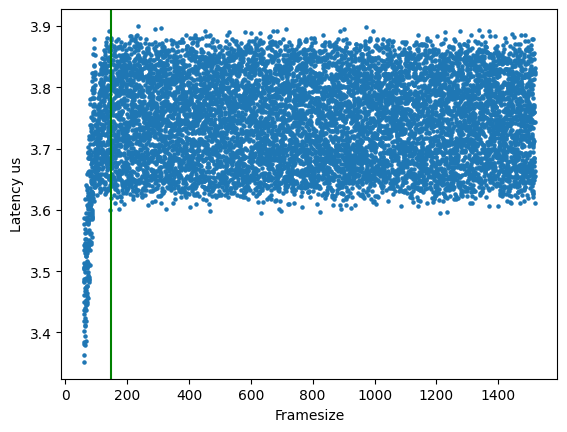

In [13]:
df_sorted = df.sort_values("Framesize").reset_index(drop=True)

bins = [b for b in range(60, 1520)]
bins.insert(0, 0)

df_sorted["bins"] = cut(df_sorted["Framesize"], bins=bins)

# print(df_sorted)
# df2 = df2.astype({"Latency LB": "int64"})

f = df_sorted.groupby('bins', group_keys=False).apply(lambda x: x.sample(min(len(x), 7))).sort_values("Framesize").reset_index(drop=True)

f.plot(x="Framesize", y="Latency us", kind="scatter", marker=".")

f[["Framesize", "Latency us"]].to_csv("/home/arch/validation_paper/kontron/cts/measurements_sampled.csv", index=False, header=True, sep="\t")
plt.axvline(x = 148, color = 'green')

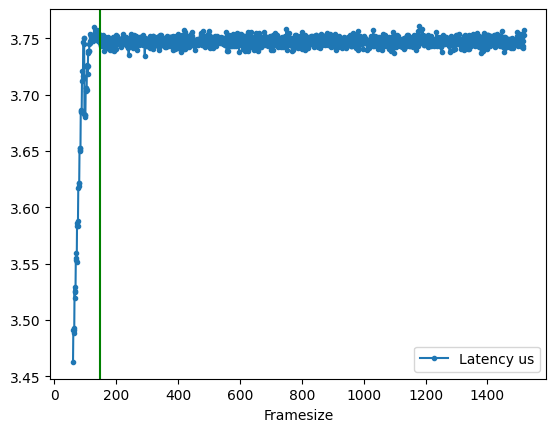

In [12]:
fs= df_sorted.groupby('bins').mean()
fs.plot(x="Framesize", y="Latency us", marker=".")
plt.axvline(x = 148, color = 'green')

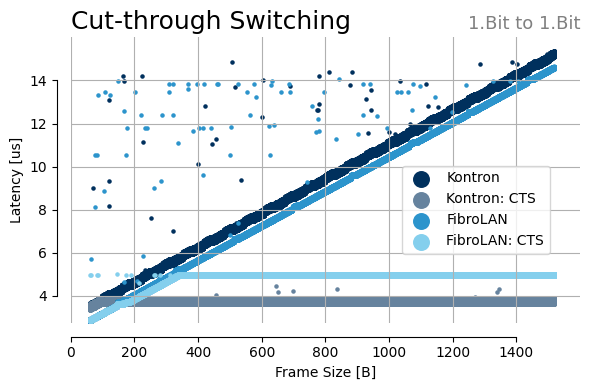

In [129]:
fig, ax = plt.subplots(figsize=(6, 4))

dfs[0].plot(x="Framesize", y="Latency us", kind="scatter", marker=".", ax=ax, color="#00305d", label="Kontron")
dfs[1].plot(x="Framesize", y="Latency us", kind="scatter", marker=".", ax=ax, color="#66839E", label="Kontron: CTS")

dfs[2].plot(x="Framesize", y="Latency us", kind="scatter", marker=".", ax=ax, color="#2C94CC", label="FibroLAN")
dfs[3].plot(x="Framesize", y="Latency us", kind="scatter", marker=".", ax=ax, color="#84CFED", label="FibroLAN: CTS")

# fs.plot(x="Framesize", y="Latency us", kind="scatter", marker=".", color="#e8412c", ax=ax, label="Mean")
# plt.axvline(x=148, color="#65b32e", label="148B")

sns.despine(offset=10, trim=True)

plt.legend(bbox_to_anchor=(0.65, 0.55), loc='upper left', borderaxespad=0, markerscale=5)
ax.set_xlabel("Frame Size [B]")
ax.set_ylabel("Latency [us]")
plt.grid(dict(visible=True,
              which='major',
              color='#CCD6DF',
              linestyle='-'))
plt.grid(dict(visible=True,
              which='minor',
              color='#CCD6DF',
              linestyle='--'))

plt.xlim((0, 1600))
plt.ylim((2.75, 16))

plt.title("Cut-through Switching", loc='left', fontsize=18)
plt.title("1.Bit to 1.Bit", loc='right', fontsize=13, color='grey')

plt.tight_layout()

plt.savefig("/home/arch/validation_paper/plot-cts.png", dpi=300)

plt.show()